In [1]:
!pip install -q torch torchvision torchaudio
!pip install -q git+https://github.com/facebookresearch/sam2.git
!pip install -q transformers groundingdino-py Pillow matplotlib opencv-python imageio_ffmpeg decord

!mkdir -p checkpoints data outputs

!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -O checkpoints/sam2_hiera_tiny.pt

!wget -q https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg -O data/truck.jpg

!wget -q https://github.com/facebookresearch/segment-anything-2/raw/main/notebooks/videos/bedroom.mp4 -O data/bedroom.mp4

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 132.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 23.9 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import subprocess, sys, cv2, torch, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.sam2_video_predictor import SAM2VideoPredictor
from IPython.display import Video, display
import imageio.v3 as iio

DATA = Path("data")
DATA.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [3]:
def load_grounding_dino():
    proc = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
    model = AutoModelForZeroShotObjectDetection.from_pretrained(
        "IDEA-Research/grounding-dino-base"
    ).to(device)
    return model, proc

def load_sam2_image():
    return SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-tiny", device=device)

def load_sam2_video():
    return SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-tiny", device=device)

In [5]:
def detect_objects(image, text_prompt, model, processor, threshold=0.25, max_objects=3):
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_grounded_object_detection(
        outputs, inputs.input_ids, target_sizes=target_sizes, threshold=threshold
    )[0]

    boxes = results["boxes"].cpu()
    scores = results["scores"].cpu()
    labels = results["labels"]

    keep = scores >= threshold
    boxes = boxes[keep][:max_objects]
    scores = scores[keep][:max_objects]
    labels = [l for l, k in zip(labels, keep)][:max_objects]

    print(f"Detected {len(boxes)} object(s) for '{text_prompt}'")
    return boxes, scores, labels

In [7]:
def segment_image(image_path, text_prompt, threshold=0.25):
    image = Image.open(image_path).convert("RGB")
    print(f"Image: {image.size}")

    grounding_model, processor = load_grounding_dino()
    boxes, scores, labels = detect_objects(image, text_prompt, grounding_model, processor, threshold)

    if len(boxes) == 0:
        print("No objects detected")
        return None, None, None, None

    sam2_predictor = load_sam2_image()
    sam2_predictor.set_image(np.array(image))

    masks_list = []
    for box in boxes:
        masks, _, _ = sam2_predictor.predict(
            point_coords=None, point_labels=None,
            box=box.cpu().numpy(), multimask_output=False
        )
        masks_list.append(torch.tensor(masks[0]))

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)

    for mask in masks_list:
        color = np.random.random(3)
        mask_np = mask.cpu().numpy()
        colored_mask = np.zeros((*mask_np.shape, 3))
        colored_mask[mask_np > 0] = color
        ax.imshow(colored_mask, alpha=0.5)

    for box in boxes:
        x0, y0, x1, y1 = box.numpy()
        rect = plt.Rectangle((x0, y0), x1-x0, y1-y0,
                            edgecolor='lime', facecolor='none', linewidth=2)
        ax.add_patch(rect)

    ax.set_title(f"'{text_prompt}'", fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    return image, masks_list, boxes, labels

In [8]:
def pad_to_mod16(img):
    h, w = img.shape[:2]
    H, W = ((h + 15) // 16) * 16, ((w + 15) // 16) * 16
    if (H, W) == (h, w):
        return img
    out = np.zeros((H, W, 3), dtype=img.dtype)
    out[:h, :w] = img
    return out

def overlay_masks(bgr, masks):
    out = bgr.copy()
    H, W = out.shape[:2]

    if masks.ndim == 2:
        masks = masks[None, ...]

    for mask in masks:
        m = np.asarray(mask)
        if m.ndim == 3:
            m = m.squeeze()
        if m.dtype != bool:
            m = m > 0.5
        if m.shape != (H, W):
            m = cv2.resize(m.astype(np.uint8), (W, H), cv2.INTER_NEAREST).astype(bool)
        if not m.any():
            continue

        color = np.random.randint(0, 255, 3, dtype=np.uint8)
        overlay = out.copy()
        overlay[m] = (0.6 * color + 0.4 * out[m]).astype(np.uint8)
        out = overlay

    return out

def segment_video(video_path, text_prompt, ann_frame=0, threshold=0.25, max_objects=3):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS) or 24.0
    frames_bgr = []
    while True:
        ok, bgr = cap.read()
        if not ok:
            break
        frames_bgr.append(bgr)
    cap.release()

    ann_frame = max(0, min(ann_frame, len(frames_bgr) - 1))
    print(f"Video: {len(frames_bgr)} frames @ {fps:.1f} fps")

    ref_pil = Image.fromarray(cv2.cvtColor(frames_bgr[ann_frame], cv2.COLOR_BGR2RGB))
    grounding_model, processor = load_grounding_dino()
    boxes, scores, labels = detect_objects(ref_pil, text_prompt, grounding_model, processor, threshold, max_objects)

    if len(boxes) == 0:
        print("No objects detected")
        return None

    predictor = load_sam2_video()
    dtype = torch.bfloat16 if device == "cuda" else torch.float32
    proc_frames_rgb = []

    with torch.inference_mode(), torch.amp.autocast(device_type=device, dtype=dtype):
        state = predictor.init_state(str(video_path))

        for i, box in enumerate(boxes):
            predictor.add_new_points_or_box(
                state, frame_idx=ann_frame, obj_id=i+1,
                box=box.numpy().astype(np.float32)
            )

        for frame_idx, obj_ids, masks in predictor.propagate_in_video(state):
            bgr = frames_bgr[frame_idx]
            mnp = masks.detach().cpu().numpy()
            bgr = overlay_masks(bgr, mnp)
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            proc_frames_rgb.append(pad_to_mod16(rgb))

    out_path = DATA / f"output_{text_prompt.replace(' ', '_')}.mp4"
    iio.imwrite(str(out_path), proc_frames_rgb, fps=fps,
                codec="libx264", output_params=["-pix_fmt", "yuv420p"])

    print(f"Saved → {out_path}")
    display(Video(str(out_path), embed=True, width=720))
    return out_path


 IMAGE SEGMENTATION 
Image: (1800, 1200)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

Detected 1 object(s) for 'truck'


/usr/local/lib/python3.12/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:94: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


sam2_hiera_tiny.pt:   0%|          | 0.00/156M [00:00<?, ?B/s]

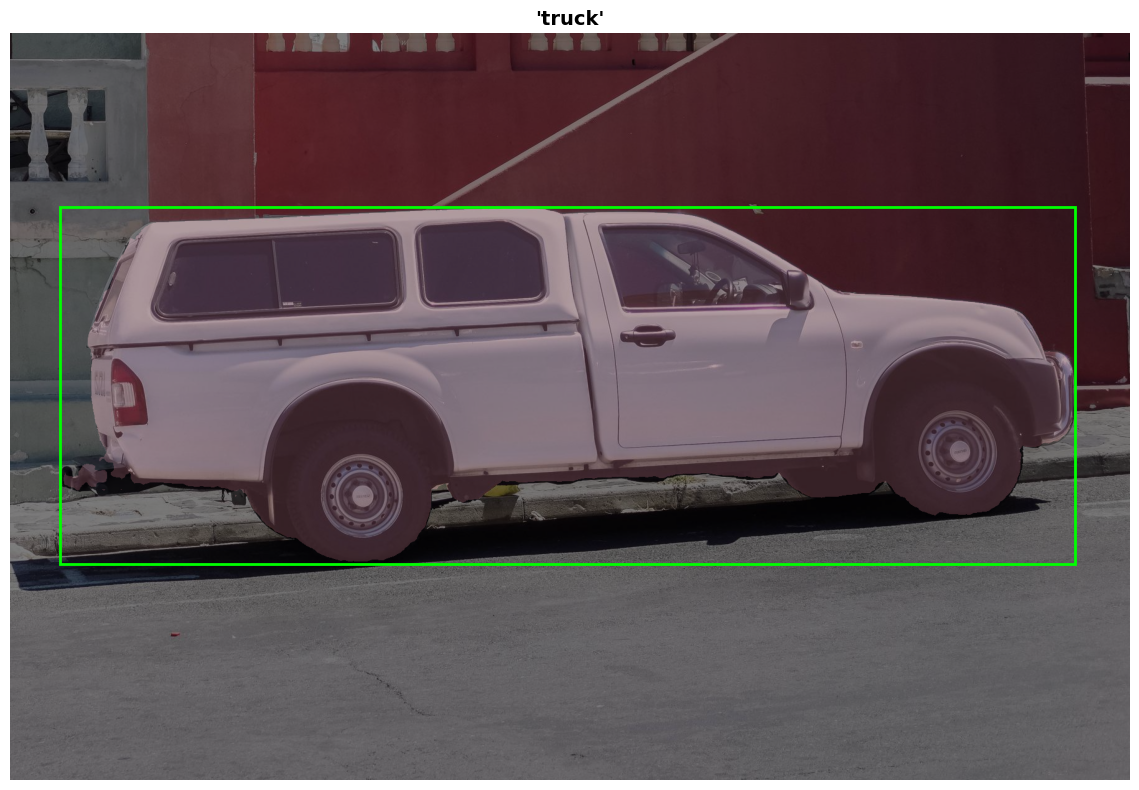


 VIDEO SEGMENTATION 
Video: 200 frames @ 30.0 fps
Detected 2 object(s) for 'bed'


propagate in video: 100%|██████████| 200/200 [02:09<00:00,  1.55it/s]


Saved → data/output_bed.mp4


In [9]:
print("\n IMAGE SEGMENTATION ")
image, masks, boxes, labels = segment_image("data/truck.jpg", "truck")

print("\n VIDEO SEGMENTATION ")
video_out = segment_video("data/bedroom.mp4", "bed", ann_frame=0, threshold=0.25, max_objects=3)